# 多输入多输出通道
:label:`sec_channels`

虽然我们在 :numref:`subsec_why-conv-channels`中描述了构成每个图像的多个通道和多层卷积层。例如彩色图像具有标准的RGB通道来指示红、绿和蓝。
但是到目前为止，我们仅展示了单个输入和单个输出通道的简化例子。
这使得我们可以将输入、卷积核和输出看作二维张量。

当我们添加通道时，我们的输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有$3\times h\times w$的形状。我们将这个大小为$3$的轴称为*通道*（channel）维度。在本节中，我们将更深入地研究具有多输入和多输出通道的卷积核。

## 多输入通道

当输入包含多个通道时，需要构造一个与输入数据具有相同输入通道数的卷积核，以便与输入数据进行互相关运算。假设输入的通道数为$c_i$，那么卷积核的输入通道数也需要为$c_i$。如果卷积核的窗口形状是$k_h\times k_w$，那么当$c_i=1$时，我们可以把卷积核看作形状为$k_h\times k_w$的二维张量。

然而，当$c_i>1$时，我们卷积核的每个输入通道将包含形状为$k_h\times k_w$的张量。将这些张量$c_i$连结在一起可以得到形状为$c_i\times k_h\times k_w$的卷积核。由于输入和卷积核都有$c_i$个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，再对通道求和（将$c_i$的结果相加）得到二维张量。这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

在 :numref:`fig_conv_multi_in`中，我们演示了一个具有两个输入通道的二维互相关运算的示例。阴影部分是第一个输出元素以及用于计算这个输出的输入和核张量元素：$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$。

![两个输入通道的互相关计算。](../img/conv-multi-in.svg)
:label:`fig_conv_multi_in`

为了加深理解，我们(**实现一下多输入通道互相关运算**)。
简而言之，我们所做的就是对每个通道执行互相关操作，然后将结果相加。


In [1]:
import torch
from d2l import torch as d2l

In [2]:
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

我们可以构造与 :numref:`fig_conv_multi_in`中的值相对应的输入张量`X`和核张量`K`，以(**验证互相关运算的输出**)。


In [3]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道

到目前为止，不论有多少输入通道，我们还只有一个输出通道。然而，正如我们在 :numref:`subsec_why-conv-channels`中所讨论的，每一层有多个输出通道是至关重要的。在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作是对不同特征的响应。而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多输出通道并不仅是学习多个单通道的检测器。

用$c_i$和$c_o$分别表示输入和输出通道的数目，并让$k_h$和$k_w$为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为$c_i\times k_h\times k_w$的卷积核张量，这样卷积核的形状是$c_o\times c_i\times k_h\times k_w$。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

如下所示，我们实现一个[**计算多个通道的输出的互相关函数**]。


In [4]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量`K`与`K+1`（`K`中每个元素加$1$）和`K+2`连接起来，构造了一个具有$3$个输出通道的卷积核。


In [5]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下面，我们对输入张量`X`与卷积核张量`K`执行互相关运算。现在的输出包含$3$个通道，第一个通道的结果与先前输入张量`X`和多输入单输出通道的结果一致。


In [6]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## $1\times 1$ 卷积层

[~~1x1卷积~~]

$1 \times 1$卷积，即$k_h = k_w = 1$，看起来似乎没有多大意义。
毕竟，卷积的本质是有效提取相邻像素间的相关特征，而$1 \times 1$卷积显然没有此作用。
尽管如此，$1 \times 1$仍然十分流行，时常包含在复杂深层网络的设计中。下面，让我们详细地解读一下它的实际作用。

因为使用了最小窗口，$1\times 1$卷积失去了卷积层的特有能力——在高度和宽度维度上，识别相邻元素间相互作用的能力。
其实$1\times 1$卷积的唯一计算发生在通道上。

 :numref:`fig_conv_1x1`展示了使用$1\times 1$卷积核与$3$个输入通道和$2$个输出通道的互相关计算。
这里输入和输出具有相同的高度和宽度，输出中的每个元素都是从输入图像中同一位置的元素的线性组合。
我们可以将$1\times 1$卷积层看作是在每个像素位置应用的全连接层，以$c_i$个输入值转换为$c_o$个输出值。
因为这仍然是一个卷积层，所以跨像素的权重是一致的。
同时，$1\times 1$卷积层需要的权重维度为$c_o\times c_i$，再额外加上一个偏差。

![互相关计算使用了具有3个输入通道和2个输出通道的 $1\times 1$ 卷积核。其中，输入和输出具有相同的高度和宽度。](../img/conv-1x1.svg)
:label:`fig_conv_1x1`

下面，我们使用全连接层实现$1 \times 1$卷积。
请注意，我们需要对输入和输出的数据形状进行微调。


In [7]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))#展平 
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

当执行$1\times 1$卷积运算时，上述函数相当于先前实现的互相关函数`corr2d_multi_in_out`。让我们用一些样本数据来验证这一点。


In [8]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [9]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 小结
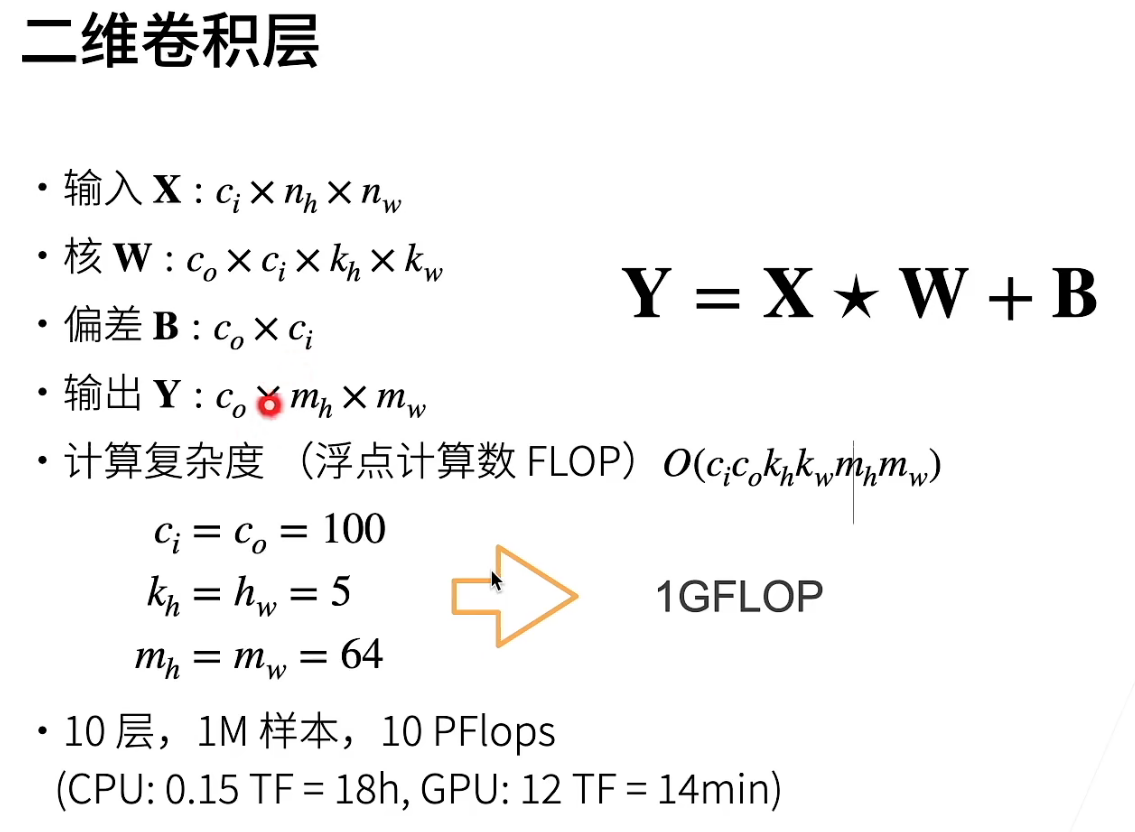
* 多输入多输出通道可以用来扩展卷积层的模型。
* 当以每像素为基础应用时，$1\times 1$卷积层相当于全连接层。
* $1\times 1$卷积层通常用于调整网络层的通道数量和控制模型复杂性。

## 练习

1. 假设我们有两个卷积核，大小分别为$k_1$和$k_2$（中间没有非线性激活函数）。
    1. 证明运算可以用单次卷积来表示。
    1. 这个等效的单卷积的维数是多少呢？
    1. 反之亦然吗？
1. 假设输入为$c_i\times h\times w$，卷积核大小为$c_o\times c_i\times k_h\times k_w$，填充为$(p_h, p_w)$，步幅为$(s_h, s_w)$。
    1. 前向传播的计算成本（乘法和加法）是多少？
    1. 内存占用是多少？
    1. 反向传播的内存占用是多少？
    1. 反向传播的计算成本是多少？
1. 如果我们将输入通道$c_i$和输出通道$c_o$的数量加倍，计算数量会增加多少？如果我们把填充数量翻一番会怎么样？
1. 如果卷积核的高度和宽度是$k_h=k_w=1$，前向传播的计算复杂度是多少？
1. 本节最后一个示例中的变量`Y1`和`Y2`是否完全相同？为什么？
1. 当卷积窗口不是$1\times 1$时，如何使用矩阵乘法实现卷积？


1. $k_1+k_2-1$
1. 
   1. ⌊(𝑛ℎ−𝑘ℎ+𝑝ℎ+𝑠ℎ)/𝑠ℎ⌋×⌊(𝑛𝑤−𝑘𝑤+𝑝𝑤+𝑠𝑤)/𝑠𝑤⌋×ci×co
   1. ci×h×w+co×ci×kh×kw+co×⌊(𝑛ℎ−𝑘ℎ+𝑝ℎ+𝑠ℎ)/𝑠ℎ⌋×⌊(𝑛𝑤−𝑘𝑤+𝑝𝑤+𝑠𝑤)/𝑠𝑤⌋
   1. co×ci×kh×kw
   1. ⌈kℎ/sℎ⌉×⌈kw/sw⌉×co×ci×kh×kw
1. 4倍。增加(ph×pw)/(sh×sw)×ci×co的计算数量
1. h×w×ci×co
1. 因为输入的X和K是浮点数，后续浮点数计算会有误差

In [ ]:
#6.
def corr2d_matmul(X, K):  
    """计算二维互相关运算。"""
    h, w = K.shape
    yh, yw = (X.shape[0] - h + 1, X.shape[1] - w + 1)
    K = K.reshape((h * w, 1))
    Y = []
    for i in range(yh):
        for j in range(yw):
            Y.append(X[i:i + h, j:j + w].reshape(h * w))
    Y = torch.stack(Y, 0)
    Y = torch.matmul(Y, K).reshape(yh, yw)
    return Y

def corr2d_multi_in_matmul(X, K):
    # 先遍历 “X” 和 “K” 的第0个维度（通道维度），再把它们加在一起
    return sum(corr2d_matmul(x, k) for x, k in zip(X, K))

def corr2d_multi_in_out_matmul(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in_matmul(X, k) for k in K], 0)